Columns
id - a unique identifier for each tweet
text - the text of the tweet
location - the location the tweet was sent from (may be blank)
keyword - a particular keyword from the tweet (may be blank)
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [3]:
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.18.0
KerasNLP version: 0.18.1


In [4]:
# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

In [6]:
# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_web_sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011719 sha256=838f7f2efc3ee34f4b60acacf6576d075726b01b4f75fbd53439450e2135e07d
  Stored in directory: /root/.cache/pip/wheels/ef/b5/d6/ea02c4952bc1e4a25991ccf516898133191812fb2a716403f7
Successfully built en_core_web_sm
  Attempting uninstall: en_core_web_sm
    Found existing installation: en-core-web-sm 3.7.1
    Uninstalling en-core-web-sm-3.7.1:
      Successfully uninstalled en-core-web-sm-3.7.1


/usr/local/lib/python3.11/dist-packages/spacy/util.py:918: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.5,<3.8.0
  warnings.warn(warn_msg)


In [7]:
# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

In [8]:
# Loading pytorch packages.

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [9]:

from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from wordcloud import WordCloud


In [10]:
# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [11]:
trainv = pd.read_csv('train.csv', sep=",")
testv  = pd.read_csv('test.csv', sep=",")

In [12]:
display(trainv.sample(5))
display(testv.sample(5))

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


,id,keyword,location,text
142,449,armageddon,1996???????????,UNIVERSAL ORDER OF ARMAGEDDON http://t.co/3tY4mGm
2672,8915,snowstorm,Los Angeles,@BigBang_CBS ...wow...ok...um...that was like ...
2605,8682,sinkhole,"New York, New York",The sinkhole that ate Brooklyn http://t.co/28r...
2515,8381,ruin,"Monroe, OH",Don't ruin a good today by thinking about a ba...
958,3187,deluge,"West Powelton, Philadelphia",I'm havin previous life flashbacks of when i l...


In [13]:
print(trainv.shape)
print(testv.shape)

(7613, 5)
(3263, 4)


In [14]:
trainv['text']= trainv["text"].str.lower()
testv['text']= testv["text"].str.lower()

In [15]:
trainv['text'] = trainv['text'].str.replace('[^\w\s]', '', regex=True)
testv['text'] = testv['text'].str.replace('[^\w\s]', '', regex=True)


In [16]:

print(trainv['text'])

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria_ahrary thetawniest the out of control wil...
7610    m194 0104 utc5km s of volcano hawaii httptcozd...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object


In [17]:
temp_df1 = pd.Series(' '.join(trainv['text']).split()).value_counts()
temp_df1

,count
the,3262
a,2176
in,1977
to,1945
of,1823
...,...
dix,1
httpstconljvp3vfyz,1
fiya,1
sourmashnumber7,1


In [18]:
temp_df2 = pd.Series(' '.join(testv['text']).split()).value_counts()
temp_df2

,count
the,1330
a,893
to,883
in,819
of,779
...,...
httptconwolqktxaf,1
httptcowrmspcpml3,1
myztiziziziziz,1
prophetmuhammad,1


In [19]:
drops1 = temp_df1[temp_df1 <= 1]
drops2 = temp_df2[temp_df2 <= 1]

In [20]:
trainv['text'] = trainv['text'].apply(lambda x: " ".join(x for x in x.split() if x not in drops1))

In [21]:
testv['text'] = testv['text'].apply(lambda x: " ".join(x for x in x.split() if x not in drops2))

In [22]:
print(trainv['text'])

0       our deeds are the reason of this earthquake ma...
1                              forest fire near la canada
2       all residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       just got sent this photo from alaska as smoke ...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria_ahrary thetawniest the out of control wil...
7610    m194 0104 utc5km s of volcano hawaii httptcozd...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object


In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=10fc0a75f0004666f95a86cba2ebc0033d1f88a6e6c65bb5889c00e51ad67aed
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [25]:
from langdetect import detect
from textblob import TextBlob

In [26]:
import nltk
from textblob import TextBlob

# Gerekli NLTK verisini indir
nltk.download('punkt_tab')

# DataFrame'de işlem yap
trainv['text'].apply(lambda x: TextBlob(x).words).head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,text
0,"[our, deeds, are, the, reason, of, this, earth..."
1,"[forest, fire, near, la, canada]"
2,"[all, residents, asked, to, shelter, in, place..."
3,"[13000, people, receive, wildfires, evacuation..."
4,"[just, got, sent, this, photo, from, alaska, a..."


In [27]:
testv['text'].apply(lambda x: TextBlob(x).words).head()

,text
0,"[just, happened, a, terrible, car, crash]"
1,"[heard, about, earthquake, is, different, citi..."
2,"[there, is, a, forest, fire, at, spot, pond, a..."
3,"[apocalypse, lighting, wildfires]"
4,"[typhoon, soudelor, kills, 28, in, china, and,..."


In [28]:
trainv['n_tokens'] = trainv['text'].apply(lambda x: len(TextBlob(x).words))


In [29]:
testv['n_tokens'] = testv['text'].apply(lambda x: len(TextBlob(x).words))

In [30]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
from textblob import Word

In [32]:
trainv['text'] = trainv['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


In [33]:
testv['text'] = testv['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


In [34]:
tf1=(trainv['text'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0))

In [35]:
tf2=(testv['text'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0))

In [36]:
tf1.columns=['words','tf1']

In [37]:
tf2.columns=['words','tf2']

In [38]:
tf2.sort_values(ascending=False)

,0
the,1330.0
a,1047.0
to,883.0
in,819.0
of,779.0
...,...
anymore,2.0
tuesday,2.0
plug,2.0
dark,2.0


In [39]:
tf1.sort_values(ascending=False)

,0
the,3262.0
a,2506.0
in,1977.0
to,1945.0
of,1823.0
...,...
httpstcolfkmtzaekk,2.0
doublecups,2.0
followback,2.0
61st,2.0


In [40]:
text = " ".join(i for i in trainv.text)

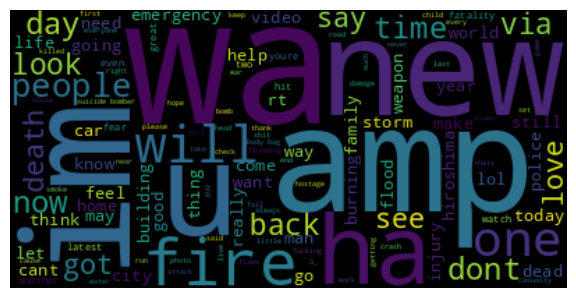

In [41]:
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [43]:
sia = SentimentIntensityAnalyzer()

In [44]:
sia.polarity_scores("The fire is new")

{'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'compound': -0.34}

In [45]:
sia.polarity_scores("Going back is hard")

{'neg': 0.318, 'neu': 0.682, 'pos': 0.0, 'compound': -0.1027}

In [46]:
trainv['text'][0:10].apply(lambda x: sia.polarity_scores(x))

,text
0,"{'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compou..."
1,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp..."
2,"{'neg': 0.099, 'neu': 0.901, 'pos': 0.0, 'comp..."
3,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
5,"{'neg': 0.146, 'neu': 0.854, 'pos': 0.0, 'comp..."
6,"{'neg': 0.255, 'neu': 0.745, 'pos': 0.0, 'comp..."
7,"{'neg': 0.158, 'neu': 0.724, 'pos': 0.118, 'co..."
8,"{'neg': 0.191, 'neu': 0.809, 'pos': 0.0, 'comp..."
9,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [47]:
trainv['text'][0:10].apply(lambda x: sia.polarity_scores(x)['compound'])

,text
0,0.2732
1,-0.3400
2,-0.2960
3,0.0000
4,0.0000
5,-0.3400
6,-0.6249
7,-0.1531
8,-0.3818
9,0.0000


In [48]:
trainv['polarity_scores'] = trainv['text'].apply(lambda x: sia.polarity_scores(x))

In [49]:

trainv["text"][0:10].apply(lambda x:"pos" if sia.polarity_scores(x)["compound"]>0 else "neg")

,text
0,pos
1,neg
2,neg
3,neg
4,neg
5,neg
6,neg
7,neg
8,neg
9,neg


In [50]:
trainv['text'][0:10].apply(lambda x: sia.polarity_scores(x)['compound'])

,text
0,0.2732
1,-0.3400
2,-0.2960
3,0.0000
4,0.0000
5,-0.3400
6,-0.6249
7,-0.1531
8,-0.3818
9,0.0000


In [51]:
trainv["sentiment_label"] = trainv["text"].apply(lambda x:"pos" if sia.polarity_scores(x)["compound"]>0 else "neg")


trainv["sentiment_label"].value_counts()

,count
sentiment_label,
neg,5590
pos,2023


In [53]:

trainv["sentiment_label"] = LabelEncoder().fit_transform(trainv["sentiment_label"])


y = trainv["sentiment_label"]
X = trainv["text"]

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

In [55]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

vectorizer.get_feature_names_out()[10:15]

array(['070', '0700', '075', '0800', '09'], dtype=object)

In [56]:
X_count.toarray()[10:15]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [57]:
log_model = LogisticRegression().fit(X_count, y)

In [58]:
cross_val_score(log_model, X_count, y, scoring="accuracy", cv=5).mean()

0.8262176197990859

In [59]:
new_rewiew = pd.Series("this product is great")


new_rewiew = vectorizer.fit(X).transform(new_rewiew)


log_model.predict(new_rewiew)

array([1])